# Project - Real or Not? NLP with Disaster Tweets

## Author: Sandro Saorin da Silva

## Description:

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies). In this project, I built a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. If you want to have access to a dataset or a Kaggle Competition about this project: [click here](https://www.kaggle.com/c/nlp-getting-started/overview).

##  

## Text Preprocessing and Data Exploration

In this section, we will prepare the Disasters Tweets data with a text preprocessing pipeline and using plot PCA and t-SNE plot try to identify some word-clusters with words of disaster and no-disaster tweets.

In [1]:
# Common's Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings('ignore') 

# Text Preprocessing Libraries

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from nltk.stem import SnowballStemmer
import re

# Metrics and NLP Vectorizer

import gensim
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning Libraries

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import xgboost as xgb
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sandro.silva/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sandro.silva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     /Users/sandro.silva/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [2]:
# Create a random_seed to use in every random_state

random_seed = 42

In [3]:
# Upload the Dataframe with tweets

df_train = pd.read_csv('train.csv')

In [4]:
# Overview from first rows of the Dataframe

df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Assess the distribution of feature 'target'

df_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [6]:
# Create a text preprocessing pipeline

stopwords = set(stopwords.words('english'))

stemmer = PorterStemmer()

# Pipeline - Text Preprocessing
def preprocessing(string):
    ###
    # Remove links withhttp/https
    string = re.sub(r'http\S+', '', string, flags=re.MULTILINE)
    ###
    # Remove hashtags
    string = re.sub(r'#(\w+)', '', string, flags=re.MULTILINE)
    ###
    # Remove mentions
    string = re.sub(r'@(\w+)', '', string, flags=re.MULTILINE)
    ###
    # Remove Numbers
    string = re.sub(r'\d', '', string)
    ###
    # Remove Special Characters
    string = re.sub(r"[^a-zA-Z0-9]+", ' ', string)
    ###
    # Lowercase words
    string = string.lower()
    ###
    # Word Tokenize
    words = word_tokenize(string)
    ###
    # Remove Stopwords
    filtered_words = []
    for w in words:
        if w not in stopwords:
            filtered_words.append(w)
    ###
    # Stemming Words
    stem_words = []
    for w in filtered_words:
        s_words = stemmer.stem(w)
        stem_words.append(s_words)
    ###
    return stem_words

In [7]:
# Apply the function in the text column and save in a new feature 'filtered words'

df_train["filtered_words"] = df_train['text'].apply(lambda x: preprocessing(x))

# For each row, join the tokens in a string

df_train['join_words'] = df_train['filtered_words'].apply(lambda x: ' '.join(x))

In [8]:
# Overview of Text Preprocessing

df_train.head()

,id,keyword,location,text,target,filtered_words,join_words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[deed, reason, may, allah, forgiv, us]",deed reason may allah forgiv us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, rong, sask, canada]",forest fire near la rong sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[resid, ask, shelter, place, notifi, offic, ev...",resid ask shelter place notifi offic evacu she...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[peopl, receiv, evacu, order, california]",peopl receiv evacu order california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[got, sent, photo, rubi, smoke, pour, school]",got sent photo rubi smoke pour school


In [9]:
# Define TF-IDF Vectorizer

tfidf = TfidfVectorizer(use_idf = True)

In [10]:
# DataViz

# Transform a dataset using TF-IDF Vectorizer and save in a DenseType

corpus_tfidf = tfidf.fit_transform(df_train['join_words'])
matrix_corpus = corpus_tfidf.todense()

In [11]:
# Use PCA to reduce to 100 dimensions

pca_red = PCA(n_components=100)
pca_corpus = pca_red.fit_transform(matrix_corpus)

In [12]:
# Use t-SNE to convert 100 dimensions to 2 coordinates

t_SNE = TSNE(n_components = 2, random_state = random_seed)
tSNE_corpus = t_SNE.fit_transform(pca_corpus)

In [13]:
# Create a new dataframe for a scatterplot

df_t_SNE = pd.DataFrame(tSNE_corpus, columns = ['x_tSNE', 'y_tSNE'])
df_scatter = pd.concat([df_t_SNE, df_train['target']], axis = 1)

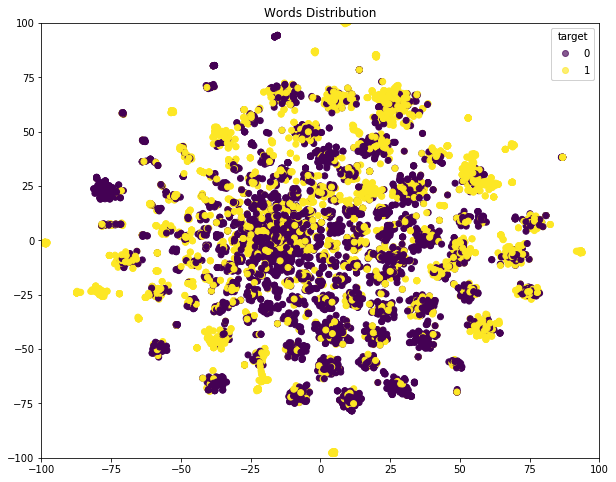

In [14]:
# Plot - Words Distribution

fig, ax = plt.subplots(figsize=(10,8))
scatter = ax.scatter(df_scatter['x_tSNE'], 
            df_scatter['y_tSNE'], 
            c = df_train['target'], 
            label = df_train['target']
           )
legend = ax.legend(*scatter.legend_elements(alpha=0.6), loc="upper right", title="target")
ax.add_artist(legend)
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.title("Words Distribution")
plt.show()

From words clustering, we can find out that don't have any well-defined separation between classes. <br>

##   

## Modelling

In this section, we will test some models to find out which one brings better results according to ROC-AUC curve.

In [15]:
# Modelling

# Create a list of ML models that will be used

list_models = [
{'model_name': 'Logistic Regression',
 'estimator' : LogisticRegression(random_state = random_seed, 
                                  solver = 'lbfgs')},
{'model_name': 'Decision Tree',
 'estimator' : DecisionTreeClassifier(random_state = random_seed)},
{'model_name': 'Random Forest',
 'estimator' : RandomForestClassifier(random_state = random_seed)},
{'model_name': 'Naive Bayes',
 'estimator' : GaussianNB()},  
{'model_name': 'XGBoost',
 'estimator' : xgb.XGBClassifier(random_state = random_seed)}
]

In [16]:
# Create a function for a TF-IDF Vectorizer and return a DenseMatrix

def TF_IDF_fit_transform(X_to_fit_and_transform, X_to_transform):
    X_fit_transformed = tfidf.fit_transform(X_to_fit_and_transform)
    X_transformed     = tfidf.transform(X_to_transform)
    return X_fit_transformed.todense(), X_transformed.todense()

In [17]:
# Create a function that receive a list of models, test each model and return all metrics and ROC-AUC curve

def test_models_plot_roc_auc_curve(model_list, col_model_name, col_model, X_train, X_val, y_train, y_val):
    for mdl in model_list:
        model = mdl[col_model]
        model.fit(X_train, y_train)
        y_predict = model.predict(X_val)
        fpr, tpr, thresholds = metrics.roc_curve(y_val, model.predict_proba(X_val)[:,1])
        auc = metrics.roc_auc_score(y_val, model.predict(X_val))
        plt.plot(fpr, tpr, label='%s ROC (AUC = %0.2f)' % (mdl[col_model_name], auc))
        print("Model      : %s" % mdl[col_model_name])
        print("Accuracy   : %0.4f " %  accuracy_score(y_val, y_predict))
        print("Precision  : %0.4f " % precision_score(y_val, y_predict, average='weighted'))
        print("Recall     : %0.4f " % recall_score(y_val, y_predict, average='weighted'))
        print("F1 - Score : %0.4f " % f1_score(y_val, y_predict, average='weighted'))
        print("ROC - AUC  : %0.4f " % auc)
        print("======================")
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC curve')
    plt.legend(loc="lower right")
    plt.show()

Model      : Logistic Regression
Accuracy   : 0.8039 
Precision  : 0.8062 
Recall     : 0.8039 
F1 - Score : 0.8004 
ROC - AUC  : 0.7875 
Model      : Decision Tree
Accuracy   : 0.7163 
Precision  : 0.7242 
Recall     : 0.7163 
F1 - Score : 0.7179 
ROC - AUC  : 0.7185 
Model      : Random Forest
Accuracy   : 0.7618 
Precision  : 0.7624 
Recall     : 0.7618 
F1 - Score : 0.7621 
ROC - AUC  : 0.7571 
Model      : Naive Bayes
Accuracy   : 0.5880 
Precision  : 0.6446 
Recall     : 0.5880 
F1 - Score : 0.5795 
ROC - AUC  : 0.6158 
Model      : XGBoost
Accuracy   : 0.7360 
Precision  : 0.7622 
Recall     : 0.7360 
F1 - Score : 0.7163 
ROC - AUC  : 0.6995 


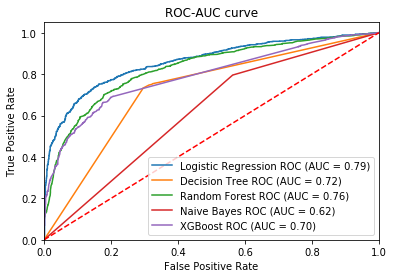

In [18]:
# Splitting the data into train and test sets

X_train, X_val, y_train, y_val = train_test_split(df_train['join_words'], 
                                                     df_train['target'], 
                                                     test_size = 0.3, 
                                                     random_state = random_seed)

X_train_tfidf, X_val_tfidf = TF_IDF_fit_transform(X_train, X_val)

test_models_plot_roc_auc_curve(list_models,
                                "model_name",
                                "estimator",
                                X_train_tfidf,
                                X_val_tfidf,
                                y_train,
                                y_val)

The ROC curve is created by plotting true positive rate against the false positive rate and the area under curve (AUC) represents degree or measure of separability, that means how much model is capable of distinguishing between TN and TP. So higher the AUC, better our model will distinguish between disasters and no-disasters tweets.<br><br>
For a list of models, the model with a highest AUC is Logistic Regression (AUC = 0,79).<br><br>

In [19]:
#Fit the best model and predict the values

clf = LogisticRegression()
clf.fit(X_train_tfidf, y_train)
y_predict_val = clf.predict(X_val_tfidf)

In [20]:
# Create a function for plot the classification report and confusion matrix

def plot_report_cmatrix(y_test,
                       y_predict,
                       labels,
                       classes,
                       normalize=False,
                       title='Confusion Matrix',
                       cmap=plt.cm.Blues):
    
    cm = confusion_matrix(y_test, y_predict, labels)
    np.set_printoptions(precision=2)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, 
               interpolation='nearest', 
               cmap=cmap,
               origin='middle')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.ylim([1.5, -.5])
    plt.xlabel('Predicted label')

    
    print('Classification Report')
    print(classification_report(y_test, y_predict))
    
    plt.show()

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1318
           1       0.82      0.68      0.75       966

    accuracy                           0.80      2284
   macro avg       0.81      0.79      0.79      2284
weighted avg       0.81      0.80      0.80      2284



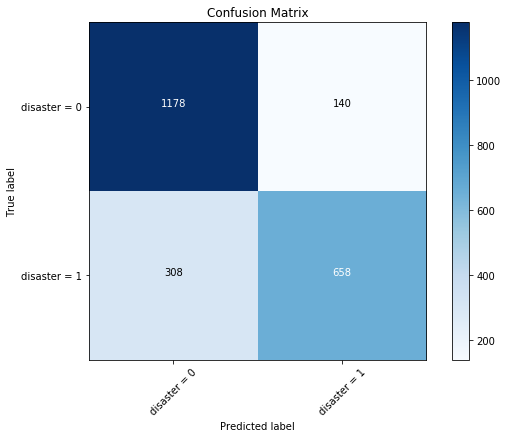

In [21]:
# Plot classification report and confusion matrix for validation dataset

plot_report_cmatrix(y_val, 
                    y_predict_val, 
                    labels = [0, 1], 
                    classes = ['disaster = 0','disaster = 1'], 
                    normalize = False, 
                    title = 'Confusion Matrix')

#  

## Threshold Selection

In this section, we will choose the best threshold for a Logistic Regression model in this problem of Disasters or No-Disasters Tweets, where will maximaze F1-Score because it guarantees a higher recall value (i.e. we will decrease number of Tweets that we classify as no-disaster but actually are disaster Tweets (False Negatives)) and a higher precision value (i.e. we will decrease number of Tweets that we classify as disaster but actually are no-disaster Tweets (False Positives)).<br>

In [22]:
# Choosing the best threshold for a Logistic Regression

# Create predict and proba for the train dataset in a new dataset

y_proba_train = clf.predict_proba(X_train_tfidf)
y_predict_train = clf.predict(X_train_tfidf)
results_train = pd.DataFrame(y_train)
results_train['proba'] = np.round(y_proba_train[:,1], 3)

In [23]:
# Overview for the new dataset

results_train.head()

,target,proba
1186,0,0.541
4071,1,0.428
5461,1,0.882
5787,1,0.491
7445,0,0.314


In [24]:
# Create predict and proba for the validation dataset in a new dataset

y_proba_val = clf.predict_proba(X_val_tfidf)
results_val = pd.DataFrame(y_val)
results_val['proba'] = np.round(y_proba_val[:,1], 3)

In [25]:
# Overview for the dataset

results_val.head()

,target,proba
2644,1,0.278
2227,0,0.235
5448,1,0.648
132,0,0.087
6845,0,0.321


In [26]:
# Looping Parameters

threshold_increment  = 0.02
threshold_begin = threshold_increment
threshold_end    = 1.0

In [27]:
# For each threshold, in a looping calculate TN, FN, FP, TP and others metrics

list_threshold  = []
list_TN         = []
list_FN         = []
list_FP         = []
list_TP         = []
list_precision  = []
list_recall     = []
list_accuracy   = []
list_f1_score   = []

for i in np.arange(threshold_begin, threshold_end + threshold_increment, threshold_increment):
    i_threshold = np.round(i, 2)
    print(str(i_threshold) + ' ', end = '')
    
    results_train['y_pred'] = results_train['proba'].apply(lambda x: 1 if x >= i_threshold else 0)
    results_train['flag_TN'] = np.where((results_train['y_pred'] == 0) & (results_train['target'] == 0), 1, 0)
    results_train['flag_FN'] = np.where((results_train['y_pred'] == 0) & (results_train['target'] == 1), 1, 0)
    results_train['flag_TP'] = np.where((results_train['y_pred'] == 1) & (results_train['target'] == 1), 1, 0)
    results_train['flag_FP'] = np.where((results_train['y_pred'] == 1) & (results_train['target'] == 0), 1, 0)
  
    TN = results_train['flag_TN'].sum()
    FN = results_train['flag_FN'].sum()
    TP = results_train['flag_TP'].sum()
    FP = results_train['flag_FP'].sum()
    
    precision = np.where((TP + FP) > 0, TP / (TP + FP), 0)
    recall = np.where((TP + FN) > 0, TP / (TP + FN), 0)
    accuracy = np.where((TN + FN + TP + FP) > 0, 
                         (TP + TN)/(TN + FN + TP + FP), 0)
    f1_score = np.where((precision + recall) > 0, (2 * precision * recall)/(precision + recall), 0)
    
    list_threshold.append(i_threshold)
    list_TN.append(TN)
    list_FN.append(FN)
    list_FP.append(FP)
    list_TP.append(TP)
    list_precision.append(np.round(precision, 4))
    list_recall.append(np.round(recall, 4))
    list_accuracy.append(np.round(accuracy, 4))
    list_f1_score.append(np.round(f1_score, 4))

#---------------------
dict_output = {
  "threshold" : list_threshold, 
  "TN" : list_TN,
  "FN" : list_FN,
  "FP" : list_FP,
  "TP" : list_TP,
  "precision" : list_precision,
  "recall" : list_recall,
  "accuracy" : list_accuracy,
  "f1_score" : list_f1_score
}

df_results = pd.DataFrame(dict_output)

0.02 0.04 0.06 0.08 0.1 0.12 0.14 0.16 0.18 0.2 0.22 0.24 0.26 0.28 0.3 0.32 0.34 0.36 0.38 0.4 0.42 0.44 0.46 0.48 0.5 0.52 0.54 0.56 0.58 0.6 0.62 0.64 0.66 0.68 0.7 0.72 0.74 0.76 0.78 0.8 0.82 0.84 0.86 0.88 0.9 0.92 0.94 0.96 0.98 1.0 

In [28]:
df_results

,threshold,TN,FN,FP,TP,precision,recall,accuracy,f1_score
0,0.02,0,0,3024,2305,0.4325,1.0000,0.4325,0.6039
1,0.04,1,0,3023,2305,0.4326,1.0000,0.4327,0.6040
2,0.06,2,0,3022,2305,0.4327,1.0000,0.4329,0.6040
3,0.08,22,0,3002,2305,0.4343,1.0000,0.4367,0.6056
4,0.10,67,0,2957,2305,0.4380,1.0000,0.4451,0.6092
5,0.12,156,1,2868,2304,0.4455,0.9996,0.4616,0.6163
6,0.14,256,2,2768,2303,0.4542,0.9991,0.4802,0.6245
7,0.16,424,7,2600,2298,0.4692,0.9970,0.5108,0.6381
8,0.18,635,11,2389,2294,0.4899,0.9952,0.5496,0.6566
9,0.20,859,20,2165,2285,0.5135,0.9913,0.5900,0.6765


Text(0.5, 1.0, 'Precision and Recall')

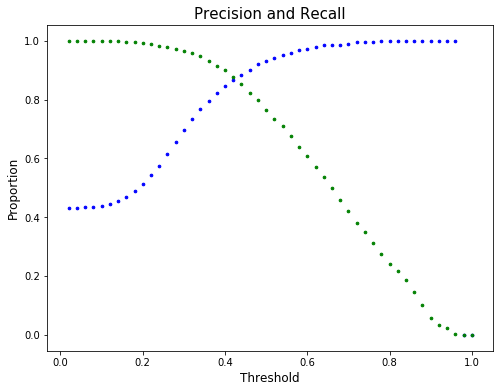

In [29]:
# Precison-Recall-Threshold Curve

k = 2
fig = plt.figure(figsize = (k*4,k*3))
ax1 = fig.add_subplot(111)
ax1.scatter(df_results['threshold'], df_results['precision'], color = 'b', s = 7)
ax1.scatter(df_results['threshold'], df_results['recall']   , color = 'g', s = 7)
ax1.set_xlabel('Threshold', fontsize = 12)
ax1.set_ylabel('Proportion', fontsize = 12)
plt.title("Precision and Recall", fontsize = 15)

[(0.0, 1.0), Text(0, 0.5, 'F1 Score'), (0.0, 1.02), Text(0.5, 0, 'Threshold')]

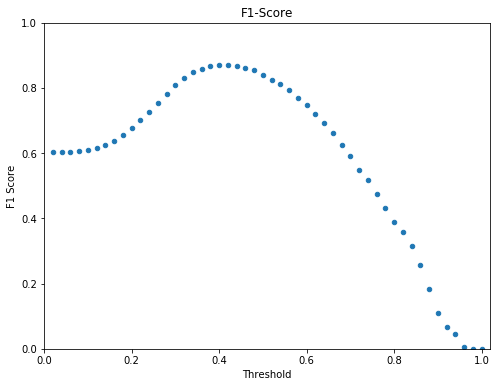

In [30]:
# F1-Score Curve

grap = df_results[df_results["threshold"] > 0.0].plot(kind="scatter", 
                                                         x="threshold", 
                                                         y="f1_score", 
                                                         grid=False, 
                                                         legend=True, 
                                                         title="F1-Score",
                                                         figsize=[8,6])
grap.set(xlabel="Threshold", 
            ylabel="F1 Score", 
            xlim=(0.0,1.02), 
            ylim=(0.0,1.0))


With a threshold value of 0,4, we will maximaze F1-Score value at 0,87. So with this threshold we will classify all tweets as disasters or no-diasters.<br>
Next steps, we will apply a threshold for predictions of training dataset and test dataset.

In [31]:
# Create y_predict using a new threshold

y_predict_train2 = np.where(y_proba_train[:,1] >= 0.4, 1, 0)

In [32]:
# Overview values of y_predict_train2

y_predict_train2

array([1, 1, 1, ..., 0, 1, 1])

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.96      0.90      3024
           1       0.93      0.77      0.84      2305

    accuracy                           0.87      5329
   macro avg       0.89      0.86      0.87      5329
weighted avg       0.88      0.87      0.87      5329



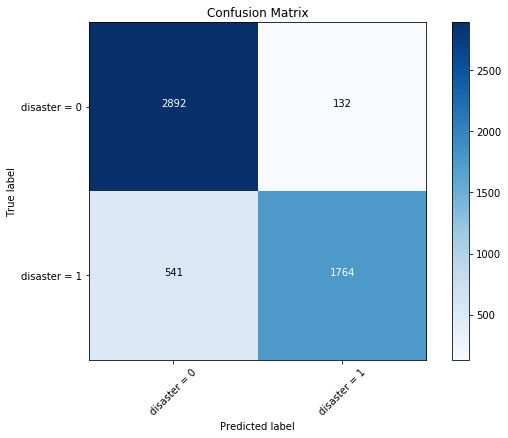

In [33]:
# Results before apply a new threshold

plot_report_cmatrix(y_train, 
                    y_predict_train, 
                    labels = [0, 1], 
                    classes = ['disaster = 0','disaster = 1'], 
                    normalize = False, 
                    title = 'Confusion Matrix')

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.87      0.90      3024
           1       0.85      0.90      0.87      2305

    accuracy                           0.88      5329
   macro avg       0.88      0.89      0.88      5329
weighted avg       0.89      0.88      0.89      5329



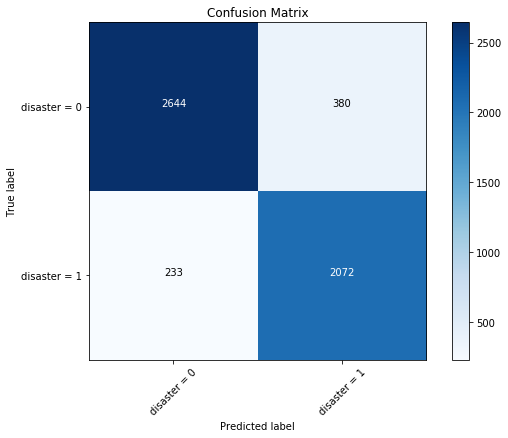

In [34]:
# Results after apply a new threshold

plot_report_cmatrix(y_train, 
                    y_predict_train2, 
                    labels = [0, 1], 
                    classes = ['disaster = 0','disaster = 1'], 
                    normalize = False, 
                    title = 'Confusion Matrix')

<br> Now applying the new threshold in test dataset.

In [35]:
# Create y_predict using a new threshold

y_predict_val2 = np.where(y_proba_val[:,1] >= 0.4, 1, 0)

In [36]:
# Overview values of y_predict_val2

y_predict_val2

array([0, 0, 1, ..., 1, 1, 1])

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1318
           1       0.82      0.68      0.75       966

    accuracy                           0.80      2284
   macro avg       0.81      0.79      0.79      2284
weighted avg       0.81      0.80      0.80      2284



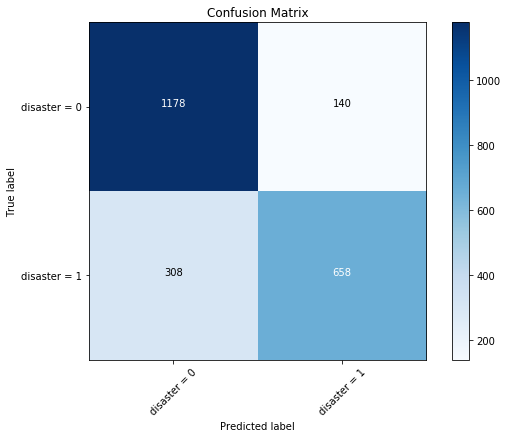

In [37]:
# Results before apply a new threshold

plot_report_cmatrix(y_val, 
                    y_predict_val, 
                    labels = [0, 1], 
                    classes = ['disaster = 0','disaster = 1'], 
                    normalize = False, 
                    title = 'Confusion Matrix')

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.77      0.80      1318
           1       0.72      0.80      0.75       966

    accuracy                           0.78      2284
   macro avg       0.78      0.78      0.78      2284
weighted avg       0.79      0.78      0.78      2284



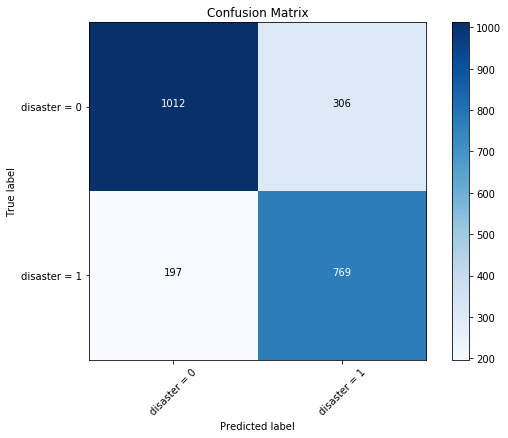

In [38]:
# Results after apply a new threshold

plot_report_cmatrix(y_val, 
                    y_predict_val2, 
                    labels = [0, 1], 
                    classes = ['disaster = 0','disaster = 1'], 
                    normalize = False, 
                    title = 'Confusion Matrix')